# Andrej Karpathy's /makemore

#### Reference
https://www.youtube.com/watch?v=TCH_1BHY58I

https://github.com/karpathy/makemore

With Bigram char level model, we only used two chars which created a 27x27 data space. if we move deeper in this approach to enhance the loss function and the model itself, the only avenue was to explor adding more dimensions, i.e. 27x27x27. however this path suddenly explodes in terms of data and parameters that we want to use for this model.

Therefore, we need to explore a better model.

## Multi Layer Perceptron (MLP)
#### Bengio et al. 2003

This is another char level model to predict the next char, however the paper is based on word predictions. 

The proposed approach is to take 'w' number of words, and associate to each word, 'm' number of feature vectors. Meaning that, each word is embedded in a 'm' dimensional feature space. Initially these words are initialized randomly but later we'll tune them using backpropagation. 

To imagine this approach, think about words that are similar or synonyms. They will end up in the same part of the space. And those that are different will be separated. 

The modeling approach is similar to the NN approach for Bigram. They use multi-layer NN to predict the next words, given the previous words. To train the NN, they ```maximize the log-likelihood of the training data```.

Let's look at an ```example``` for this approach. Assume, we are not given the sentence "A dog was running in a room". But now for testing the model we are providing it with "A dog was running in a ..." and expecting the model to fill in the blank. Since it hasn't seen this exact sentence, we call it, ```out of distribution```. However, MLP doesn't need to have seen the exact words to predict 'room' for the blank. Because it might have seen "The dog was running in a room" and based on the learnings, it has put the embeddings of 'The' and 'A' near by each other in the space. So now that we are asking it to fill the blank based on "A dog was running in a ...", it will match it up with "The dog was running in a room". This is called ```knowledge transfer```.

Let's look at the ```architecture``` of this approach. 

Assume the NN's input, takes 3 previous-words. And the output is the fourth word. Each of the incoming words, will go through a look-up table, to match up the corresponding embedding ('m' feature vector) for that word. So there will be $3 \times m$ neurons holding the 3 words. 

Then we need to build a hidden layer. The size is a ```hyper-parameter```. Meaning that, we need to come up with the right size based on try-error. So all the input neurons goes into the hidden layer. And there will be a ```tanh``` function applied for non-linearity. 

The output layer is a huge one, because the number of neurons is equivalent to $w$, the number of words in our data set. All the neurons in the hidden layer are connected to the output neurons. That's why there will be lots of params in between these two layers, and therefore, it's going to be computationally expensive. On top of the output layer we have ```softmax``` (exponentiate the logits and normalize, so that it will sum up to 1). This way, we'll get a nice probability distribution for the next word in the sequence. 

During training, because we have xs and ys, we will get the probability for each x and minimize the NN's loss by improving the parameters. The optimization used here is also ```backpropagation```.

In [44]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
import os

# read from another package while we are in a separate package
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
file_path = os.path.join(parent_directory, 'opensource/makemore', 'names.txt')

words = open(file_path, 'r').read().splitlines()

words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [46]:
# build the vocabulary of chars and mappings to/from integers
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i,s in enumerate(chars)}
s2i['.'] = 0
i2s = {i:s for s,i in s2i.items()}
print(i2s)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


#### build the dataset

In [47]:
# build the dataset

block_size = 3 # context length: how many chars do we take to predict the next char, 4-th one
X, Y = [], []
for w in words[:5]: # the examples we can generate from the first 5 words
    print(w)
    context = [0] * block_size
    for ch in w + '.': # we are padding with dots, because if the word doesn't have enough chars to cover for our block_size, we'll have something to build
        ix = s2i[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(i2s[i] for i in context), '--->', i2s[ix])
        context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [48]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [49]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

#### Build The Embeddings

the paper used 70000 words with 30 embeddings. we have 27 chars, so we'll go with 2 embeddings.

In [50]:
C = torch.randn((27, 2))
C[5]

tensor([1.3023, 0.4651])

In [51]:
# retrieve embeddings with a list of lookups
C[[5,6,8]]

tensor([[ 1.3023,  0.4651],
        [ 0.5387, -0.0413],
        [-1.8265, -0.3889]])

In [52]:
# therefore this works
emb = C[X]
emb

tensor([[[ 0.4650, -0.2010],
         [ 0.4650, -0.2010],
         [ 0.4650, -0.2010]],

        [[ 0.4650, -0.2010],
         [ 0.4650, -0.2010],
         [ 1.3023,  0.4651]],

        [[ 0.4650, -0.2010],
         [ 1.3023,  0.4651],
         [-0.1166,  0.3032]],

        [[ 1.3023,  0.4651],
         [-0.1166,  0.3032],
         [-0.1166,  0.3032]],

        [[-0.1166,  0.3032],
         [-0.1166,  0.3032],
         [ 0.6645,  0.7288]],

        [[ 0.4650, -0.2010],
         [ 0.4650, -0.2010],
         [ 0.4650, -0.2010]],

        [[ 0.4650, -0.2010],
         [ 0.4650, -0.2010],
         [-0.6195,  0.3101]],

        [[ 0.4650, -0.2010],
         [-0.6195,  0.3101],
         [-0.5541, -1.7226]],

        [[-0.6195,  0.3101],
         [-0.5541, -1.7226],
         [ 0.6410,  1.1742]],

        [[-0.5541, -1.7226],
         [ 0.6410,  1.1742],
         [ 0.3023, -0.8974]],

        [[ 0.6410,  1.1742],
         [ 0.3023, -0.8974],
         [ 0.6410,  1.1742]],

        [[ 0.3023, -0

#### hidden layer

In [53]:
hidden_layer_hyperparameter_size = 100
num_of_words = 3
num_of_embeddings = 2
num_of_inputs = num_of_words * num_of_embeddings

w1 = torch.randn((num_of_inputs, hidden_layer_hyperparameter_size))
b1 = torch.randn((hidden_layer_hyperparameter_size))



In [54]:
X.shape

torch.Size([32, 3])

In [55]:
C.shape

torch.Size([27, 2])

In [56]:
emb.shape

torch.Size([32, 3, 2])

In [57]:
w1.shape

torch.Size([6, 100])

wee want to setup the tensor's shapes in such a way that ```emb @ w1 + b1``` would work.

http://blog.ezyang.com/2019/05/pytorch-internals/


In [58]:
x_size = emb.shape[0] # or use -1 for pytorch to figure it out
emb.view(x_size, num_of_inputs) @ w1 + b1

tensor([[-1.8953, -1.6409, -0.8250,  ...,  2.2597,  1.3783,  0.8145],
        [-0.9660, -2.4800,  1.8895,  ...,  3.9144,  0.9641,  1.3991],
        [-3.2081, -3.9777, -2.2143,  ...,  1.2977,  2.3624,  2.4231],
        ...,
        [-3.9781,  2.3380, -6.9441,  ..., -2.1299,  0.5283, -0.0794],
        [ 3.7887,  5.4175,  3.0423,  ..., -0.4846,  0.2327,  0.2111],
        [-3.1855, -3.7977,  1.1798,  ...,  4.1962,  1.2162,  2.1287]])

In [59]:
# hidden layer
h = torch.tanh(emb.view(-1, num_of_inputs) @ w1 + b1) # added tanh to bring all the values between -1 and 1 for non-linearity
h 

tensor([[-0.9558, -0.9276, -0.6778,  ...,  0.9784,  0.8806,  0.6721],
        [-0.7469, -0.9861,  0.9553,  ...,  0.9992,  0.7461,  0.8852],
        [-0.9967, -0.9993, -0.9764,  ...,  0.8611,  0.9824,  0.9844],
        ...,
        [-0.9993,  0.9815, -1.0000,  ..., -0.9721,  0.4841, -0.0793],
        [ 0.9990,  1.0000,  0.9955,  ..., -0.4499,  0.2286,  0.2080],
        [-0.9966, -0.9990,  0.8274,  ...,  0.9995,  0.8385,  0.9721]])

#### output layer

In [60]:
# output layer
w2 = torch.randn((hidden_layer_hyperparameter_size, 27))
b2 = torch.randn((27))
logits = h @ w2 + b2
logits.shape

torch.Size([32, 27])

In [61]:
counts = logits.exp() # get fake counts
probs = counts / counts.sum(1, keepdim=True) # normalize to get the probabilities
probs.shape


torch.Size([32, 27])

In [62]:
# proof of normalized probs is to check if every row sums up to =1
probs[0].sum()

tensor(1.0000)

In [63]:
probs[torch.arange(32), Y]

tensor([2.4305e-04, 6.4292e-01, 2.0060e-06, 1.7346e-01, 1.8115e-05, 6.0897e-03,
        1.8932e-06, 5.3520e-06, 6.0917e-03, 2.7039e-05, 4.8216e-09, 3.3954e-08,
        1.7566e-02, 7.4114e-03, 6.1974e-01, 5.5244e-13, 7.1050e-04, 2.7553e-04,
        1.0000e+00, 4.2845e-07, 3.3437e-13, 6.6014e-11, 4.8313e-13, 2.2374e-08,
        1.3035e-17, 1.7353e-04, 1.1354e-06, 2.6870e-06, 1.8639e-12, 2.5290e-04,
        4.5072e-08, 2.4664e-08])

#### Training on Small Dataset (over-fitting)

we haven't trained the NN yet so the probabilities are far from 1.

In [64]:
# we need to minimize this loss
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(13.3317)

let's put everything together

In [65]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((num_of_inputs, hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
b1 = torch.randn((hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
W2 = torch.randn((hidden_layer_hyperparameter_size, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [66]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [67]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp() # (32, 27)
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697, grad_fn=<NegBackward0>)

instead of using the above code we can also use pytorch library to arrive at the same loss, which is more efficient. 

In [68]:
F.cross_entropy(logits, Y)

tensor(17.7697, grad_fn=<NllLossBackward0>)

let's setup the training procedure

In [69]:
for _ in range(100):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print('loss -> ', loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data.add_(-0.1 * p.grad)

loss ->  17.769712448120117
loss ->  13.656402587890625
loss ->  11.298768997192383
loss ->  9.4524564743042
loss ->  7.984262943267822
loss ->  6.891320705413818
loss ->  6.100014686584473
loss ->  5.452036380767822
loss ->  4.898151874542236
loss ->  4.414663791656494
loss ->  3.985849380493164
loss ->  3.6028308868408203
loss ->  3.2621421813964844
loss ->  2.961381435394287
loss ->  2.6982975006103516
loss ->  2.469712734222412
loss ->  2.271660566329956
loss ->  2.101283550262451
loss ->  1.9571772813796997
loss ->  1.8374857902526855
loss ->  1.7380967140197754
loss ->  1.653511643409729
loss ->  1.5790899991989136
loss ->  1.5117664337158203
loss ->  1.449604868888855
loss ->  1.3913118839263916
loss ->  1.3359922170639038
loss ->  1.2830528020858765
loss ->  1.2321910858154297
loss ->  1.18338143825531
loss ->  1.136798620223999
loss ->  1.092664122581482
loss ->  1.051092267036438
loss ->  1.0120269060134888
loss ->  0.9752703309059143
loss ->  0.940556526184082
loss ->  0.907

so far we reached above optimized loss with 5 words and 32 examples. so let's pull in all the data.

#### Training On Full Dataset

In [70]:
# build the dataset

block_size = 3 # context length: how many chars do we take to predict the next char, 4-th one
X, Y = [], []
for w in words: # the examples we can generate from the first 5 words
    context = [0] * block_size
    for ch in w + '.': # we are padding with dots, because if the word doesn't have enough chars to cover for our block_size, we'll have something to build
        ix = s2i[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [71]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((num_of_inputs, hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
b1 = torch.randn((hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
W2 = torch.randn((hidden_layer_hyperparameter_size, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [72]:
for _ in range(100):
    # forward pass
    emb = C[X] 
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y)
    print('loss -> ', loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data.add_(-0.1 * p.grad)

loss ->  19.505229949951172
loss ->  17.084482192993164
loss ->  15.776532173156738
loss ->  14.833340644836426
loss ->  14.002605438232422


loss ->  13.253263473510742
loss ->  12.57991886138916
loss ->  11.983102798461914
loss ->  11.47049331665039
loss ->  11.05185604095459
loss ->  10.709586143493652
loss ->  10.407631874084473
loss ->  10.127808570861816
loss ->  9.864364624023438
loss ->  9.614501953125
loss ->  9.376439094543457
loss ->  9.148944854736328
loss ->  8.931110382080078
loss ->  8.722230911254883
loss ->  8.521749496459961
loss ->  8.329227447509766
loss ->  8.144325256347656
loss ->  7.966791152954102
loss ->  7.796450614929199
loss ->  7.633185386657715
loss ->  7.476908206939697
loss ->  7.327521800994873
loss ->  7.184885501861572
loss ->  7.048792362213135
loss ->  6.9189534187316895
loss ->  6.795018196105957
loss ->  6.6766037940979
loss ->  6.563319206237793
loss ->  6.4547905921936035
loss ->  6.350669860839844
loss ->  6.250644207000732
loss ->  6.154432773590088
loss ->  6.06178617477417
loss ->  5.972483158111572
loss ->  5.88632869720459
loss ->  5.8031487464904785
loss ->  5.722784519195557


#### Mini-Batch

The reason why above training takes a lot of time is that, it's doing a forward and backward pass on a large dataset. To optimize the training process we introduce mini-batches. 

With mini-batch, we do the forward and backward passes on a smaller dataset. Once optimized we move to another batch for training and optimizing the loss.

In [73]:
for _ in range(1000):

    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,)) # 32 random integers between 0 and X.shape[0]. this will make the batch size 32

    # forward pass
    emb = C[X[ix]] # instead of sending the entire X for mapping, we can only iterate over the batch size
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y[ix]) # labels are also only for the batch size too
    print('loss -> ', loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data.add_(-0.1 * p.grad)

loss ->  3.1884219646453857
loss ->  2.6396396160125732
loss ->  3.610919237136841
loss ->  3.5851998329162598
loss ->  3.5940868854522705
loss ->  3.5498619079589844
loss ->  3.665818929672241
loss ->  3.285625696182251
loss ->  2.651365280151367
loss ->  3.231239080429077
loss ->  3.1525485515594482
loss ->  4.06334114074707
loss ->  3.3632075786590576
loss ->  3.2622134685516357
loss ->  3.379981756210327
loss ->  2.9979629516601562
loss ->  3.654086112976074
loss ->  3.3383402824401855
loss ->  4.203357696533203
loss ->  3.4861645698547363
loss ->  3.7279107570648193
loss ->  4.203322410583496
loss ->  3.948085308074951
loss ->  3.5631096363067627
loss ->  3.4001104831695557
loss ->  3.1193482875823975
loss ->  3.2921817302703857
loss ->  3.7679190635681152
loss ->  2.769350290298462
loss ->  3.3689568042755127
loss ->  3.662027359008789
loss ->  3.27282452583313
loss ->  3.299266815185547
loss ->  3.092632532119751
loss ->  3.3296799659729004
loss ->  3.416055202484131
loss ->  3.

loss ->  3.2446959018707275
loss ->  3.3627681732177734
loss ->  3.1986143589019775
loss ->  3.773404598236084
loss ->  3.751447916030884
loss ->  3.195234537124634
loss ->  3.9484617710113525
loss ->  3.4398956298828125
loss ->  4.073247909545898
loss ->  2.7067341804504395
loss ->  3.398693084716797
loss ->  3.573239803314209
loss ->  3.8909106254577637
loss ->  3.0182156562805176
loss ->  3.5211079120635986
loss ->  3.1365466117858887
loss ->  3.2156403064727783
loss ->  3.786299467086792
loss ->  3.3963048458099365
loss ->  3.1231532096862793
loss ->  3.041530132293701
loss ->  3.753558874130249
loss ->  3.0077710151672363
loss ->  3.538760185241699
loss ->  2.8724145889282227
loss ->  2.533097982406616
loss ->  3.139467716217041
loss ->  2.7051522731781006
loss ->  3.2663731575012207
loss ->  3.3483805656433105
loss ->  3.2062134742736816
loss ->  2.580139636993408
loss ->  3.5793402194976807
loss ->  3.56064510345459
loss ->  3.064148426055908
loss ->  3.37174129486084
loss ->  2

now you can see that thee training is much faster and therefore, you can afford to increase the iterations for further minimizing the loss.

#### Learning Rate

How do you determine the learning rate? How do you know if it's too small (moving too slowly towards an optimized loss), or it's too big (over-stepping and missing the optimized loss)?

One way is to find the min and max range, first. You can provide -0.0001 or lower and find the value that demonstrates a reasonable decrease in the loss. Then find a big number with the same analogy. Based in this, we can see that, the optimized learning rate should be between -0.001 and -1.

We can use pytorch's library to create a linear array of learning rates between these two numbers for, say 1000 steps.

In [74]:
lre = torch.linspace(-3, 0, 1000) # linear rate exponential
lrs = 10**lre # learning rates: 10^-3 = 0.001 and 10^0 = 1
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

now let's reset everything and iterate through possible learning rates to find the best match

In [75]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((num_of_inputs, hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
b1 = torch.randn((hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
W2 = torch.randn((hidden_layer_hyperparameter_size, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters) # number of parameters in total

3481

loss ->  17.818588256835938
loss ->  17.207744598388672
loss ->  17.988798141479492
loss ->  20.785329818725586
loss ->  20.873462677001953
loss ->  18.135498046875
loss ->  18.609798431396484
loss ->  20.673307418823242
loss ->  16.66250228881836
loss ->  21.12810516357422
loss ->  17.779855728149414
loss ->  17.02388572692871
loss ->  15.62646770477295
loss ->  18.628421783447266
loss ->  17.707677841186523
loss ->  18.769920349121094
loss ->  19.127243041992188
loss ->  17.14310646057129
loss ->  20.252927780151367
loss ->  22.728914260864258
loss ->  19.412267684936523
loss ->  22.063735961914062
loss ->  18.95575714111328
loss ->  18.117475509643555
loss ->  19.736312866210938
loss ->  17.780424118041992
loss ->  18.236976623535156
loss ->  22.279130935668945
loss ->  17.801116943359375
loss ->  17.21622657775879
loss ->  16.967979431152344
loss ->  17.564491271972656
loss ->  17.102432250976562
loss ->  21.47294044494629
loss ->  18.45301055908203
loss ->  19.186065673828125
loss

loss ->  8.6114501953125
loss ->  9.79350757598877
loss ->  10.733607292175293
loss ->  10.819635391235352
loss ->  11.903679847717285
loss ->  13.183263778686523
loss ->  10.20171070098877
loss ->  12.106488227844238
loss ->  13.204911231994629
loss ->  10.672565460205078
loss ->  10.946775436401367
loss ->  10.51285171508789
loss ->  11.21959114074707
loss ->  12.171158790588379
loss ->  10.082282066345215
loss ->  9.49066162109375
loss ->  11.373885154724121
loss ->  13.22693920135498
loss ->  10.17165470123291
loss ->  8.857242584228516
loss ->  10.976099967956543
loss ->  10.234500885009766
loss ->  11.430596351623535
loss ->  9.86681079864502
loss ->  9.83964729309082
loss ->  12.072699546813965
loss ->  7.562723159790039
loss ->  9.785326957702637
loss ->  10.59708309173584
loss ->  8.06691837310791
loss ->  9.147026062011719
loss ->  10.198055267333984
loss ->  9.455120086669922
loss ->  9.41597843170166
loss ->  9.17795181274414
loss ->  7.488502502441406
loss ->  9.4147500991

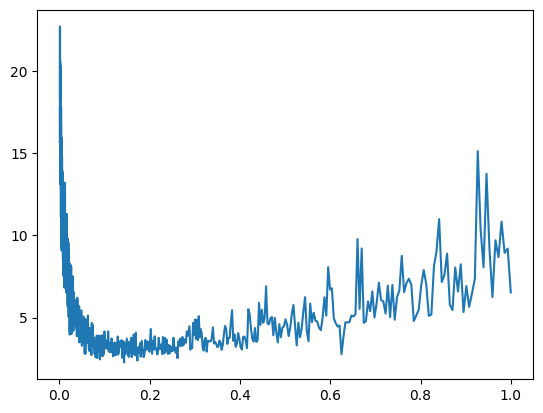

In [76]:
# track the learning rates in respect to its loss
lr_i = []
loss_i = []

for i in range(1000):

    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,)) # 32 random integers between 0 and X.shape[0]. this will make the batch size 32

    # forward pass
    emb = C[X[ix]] # instead of sending the entire X for mapping, we can only iterate over the batch size
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y[ix]) # labels are also only for the batch size too
    print('loss -> ', loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data.add_(-lr * p.grad)

    lr_i.append(lr)
    loss_i.append(loss.item())

plt.plot(lr_i, loss_i)

as you can see the learning rate was stable between 0.0 and 0.1, and after that it became unstable. So we have narrowed down the learning rate's range in respect to minimized loss function. So we can choose 0.1 safely now and also increase the iteration.

In [77]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((num_of_inputs, hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
b1 = torch.randn((hidden_layer_hyperparameter_size), generator=g, requires_grad=True)
W2 = torch.randn((hidden_layer_hyperparameter_size, 27), generator=g, requires_grad=True)
b2 = torch.randn((27), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [78]:
for i in range(10000):

    # mini-batch
    ix = torch.randint(0, X.shape[0], (32,)) # 32 random integers between 0 and X.shape[0]. this will make the batch size 32

    # forward pass
    emb = C[X[ix]] # instead of sending the entire X for mapping, we can only iterate over the batch size
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y[ix]) # labels are also only for the batch size too
    # print('loss -> ', loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data.add_(-0.1 * p.grad)

In [79]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
print('loss -> ', loss.item())

loss ->  2.4760119915008545


#### Learning Rate Decay

One more thing to remember is that, once we found our optimized learning rate, we can run the training with it a few times. But then you realize the loss is not moving lower by much. In that case, on a trained NN, you can further reduce the learning rate, by a factor of 10, and continue thee training with same amount of iterations. You can continue this until you reach a plateau. This approach is called learning decay.

#### Data Split - Train/Validate/Test

If you increase your parameters to exceed your input size, you will end up over-fitting the data. Meaning that, your NN will memorize the data and outputs exactly what it saw, rather then being creative and output something new. 

To make sure we are not over-fitting or under-fitting we can split the data into training (80%), validation/dev (10%), and testing sets (10%). 

Validation is used to find the best hyper-params and settings of the NN. You can try multiple variations to evaluate which one is best for your data.

#### Code Wrap-up

In [80]:
# build the vocabulary of chars and mappings to/from integers
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i,s in enumerate(chars)}
s2i['.'] = 0
i2s = {i:s for s,i in s2i.items()}
vocab_size = len(i2s)

# MPL model
n_emb = 10 # the dimension of the character embedding vector
n_hidden = 200 # The number of neurons in the hidden layer of MLP
block_size = 3 # context length: how many chars do we take to predict the next char, 4-th one

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb),                generator=g, requires_grad=True)
W1 = torch.randn((n_emb * block_size, n_hidden),    generator=g, requires_grad=True)
b1 = torch.randn((n_hidden),                        generator=g, requires_grad=True)
W2 = torch.randn((n_hidden, vocab_size),            generator=g, requires_grad=True)
b2 = torch.randn((vocab_size),                      generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [81]:
# build the dataset

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = s2i[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# split the dataset randomly for train, dev and test
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words)) # 80% of the words
n2 = int(0.9 * len(words)) # 90% of the words

Xtr, Ytr = build_dataset(words[:n1]) # train on 80% of the words
Xdev, Ydev = build_dataset(words[n1:n2]) # validate on 10% of the words
Xtst, Ytst = build_dataset(words[n2:]) # test on 10% of the words

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [82]:
max_steps = 200000
batch_size = 32
lossi = []

def train_NN(X,Y):
    
    for i in range(max_steps):

        # mini-batch
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g) # 32 random integers between 0 and X.shape[0]. this will make the batch size 32

        # forward pass
        emb = C[X[ix]] # instead of sending the entire X for mapping, we can only iterate over the batch size
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Y[ix]) # labels are also only for the batch size too
        # print('loss -> ', loss.item())

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay after 100k steps
        for p in parameters:
            p.data.add_(-lr * p.grad)

        # track stats
        if i % 1000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

@torch.no_grad()
def getLoss(X,Y):
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print('loss -> ', loss.item())            

In [83]:
# train
train_NN(Xtr, Ytr)


      0/ 200000: 27.8817
   1000/ 200000: 4.2208
   2000/ 200000: 2.9934
   3000/ 200000: 2.9829
   4000/ 200000: 2.2823
   5000/ 200000: 2.4180
   6000/ 200000: 2.4152
   7000/ 200000: 2.8149
   8000/ 200000: 2.5133
   9000/ 200000: 2.5542
  10000/ 200000: 2.8619
  11000/ 200000: 2.0939
  12000/ 200000: 2.4401
  13000/ 200000: 2.4719
  14000/ 200000: 2.9341
  15000/ 200000: 2.3488
  16000/ 200000: 2.6091
  17000/ 200000: 2.7315
  18000/ 200000: 2.4622
  19000/ 200000: 2.4676
  20000/ 200000: 2.5443
  21000/ 200000: 2.6354
  22000/ 200000: 2.1334
  23000/ 200000: 2.2140
  24000/ 200000: 3.0568
  25000/ 200000: 2.3262
  26000/ 200000: 2.5554
  27000/ 200000: 2.6473
  28000/ 200000: 2.3433
  29000/ 200000: 3.2092
  30000/ 200000: 2.8801
  31000/ 200000: 2.6749
  32000/ 200000: 2.5013
  33000/ 200000: 2.5535
  34000/ 200000: 2.1968
  35000/ 200000: 2.5608
  36000/ 200000: 2.1742
  37000/ 200000: 2.2611
  38000/ 200000: 2.9491
  39000/ 200000: 2.2258
  40000/ 200000: 2.0870
  41000/ 200000

if the loss of the training dataset and validation set are too different, that means that our NN hasn't learned much.

To visualize how the embeddings change after randomly setting them up and training the NN, run below code.

In [84]:
# training data loss
getLoss(Xtr, Ytr)
# validation loss
getLoss(Xdev, Ydev)


loss ->  2.1294455528259277
loss ->  2.173779249191284


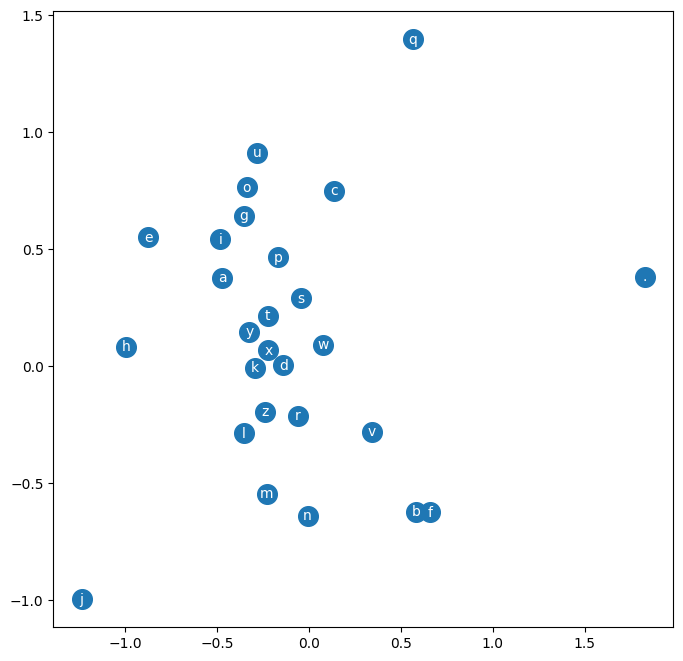

In [85]:
# plot the embeddings

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), i2s[i], ha='center', va='center', color='white')

In [86]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 1000)

for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[torch.tensor([context])] 
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) 
        logits = h @ W2 + b2 
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: # stop at the end of the word
            break
    print(''.join(i2s[i] for i in out))


naitabree.
jaezi.
aje.
maxanley.
lei.
jacaraanly.
erilameenah.
ell.
adalisa.
ere.


at this point you can start working on the possible configuration tunings and improve your loos and validations.